# Global adaptive time-stepping for a locally compressed monolayer due to a single proliferation event with fixed cells

# Looking at eigenvalues and eigenvectors

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 10.0  # final time
rA = 1.5   # maximum interaction distance
separation = 0.3 # initial separation between daughter cells

dim = 2

seed=67
npr.seed(seed)

dt = 0.05
t_data = np.arange(0, tf, dt)

force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}

# Solvers
models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
             'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, dim)}
#models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
#             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
 #            'GLS': cbmos.CBModel(ff.LinearExponential(), ef.solve_ivp, dim)}

In [3]:
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}
filename_ending = {'cubic': '_cubic', 'pw. quad.': '_pwq', 'GLS': '_gls'}

In [4]:
def cubic_prime(r, mu, s, rA):
    return mu*(r-rA)*(3*r-2*s-rA)
    
def pwq_prime(r, muA, rA, muR, rR, s):
    return 2*(muR/rR*(1-r/rR)-muA/rA*(1-r/rA))
    
def gls_prime(r, mu, s):
    return mu/(1+r-s)

In [5]:
def make_hexagonal_mesh(l):
# 2D honeycomb mesh
#l=3
    n_x = l+(l//2)+((l-1)//2)
    n_y = l+(l-1)
    xcrds = [(2 * i + (j % 2)) * 0.5 for j in range(n_y) for i in range(n_x)]
    ycrds = [np.sqrt(3) * j * 0.5 for j in range(n_y) for i in range(n_x)]

    # make cell_list for the sheet
    sheet = [cl.Cell(i, [x,y], 0.0, proliferating=False) for i, x, y in zip(range(n_x*n_y), xcrds, ycrds)]

    # delete cells to make it circular - skip for now
    #del sheet[24]
    #del sheet[20]
    #del sheet[19]
    #del sheet[3*l+1+3+1]
    #del sheet[2*l+1+3]
    #del sheet[2*l+1+2]
    #del sheet[l+1]
    #del sheet[0]

    # find middle index, move cell there and add second daughter cells
    m = n_x *(n_y//2)+ n_x//2
    coords = list(sheet[m].position)
    
    # get division direction
    random_angle = 2.0 * np.pi * npr.rand()
    division_direction = np.array([np.cos(random_angle), np.sin(random_angle)])
    
    # update positions
    updated_position_parent = coords - 0.5 * separation * division_direction
    sheet[m].position = updated_position_parent   

    position_daughter = coords + 0.5 * separation * division_direction    
    
    # add daughter cell
    next_cell_index = len(sheet)
    daughter_cell = cl.Cell(next_cell_index, position_daughter, birthtime=0.0, proliferating=False)
    sheet.append(daughter_cell)
        
    return sheet

In [6]:
# plot function
def plot_population(cell_list, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    for i in range(n_cells):
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
    plt.show()

In [7]:
# plot function
# eigenvector must contain eigenvector corresponding to a single eigenvalue
def plot_eigenvector_on_population(cell_list, eigenvector, n0, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    eigenvector = eigenvector.reshape((n_cells-n0, -1))
    for i in range(n_cells):            
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
        if i >= n0:
            plt.plot([cell_list[i].position[0], cell_list[i].position[0] + eigenvector[i-n0, 0]], [cell_list[i].position[1],cell_list[i].position[1]+eigenvector[i-n0,1]])
    plt.show()

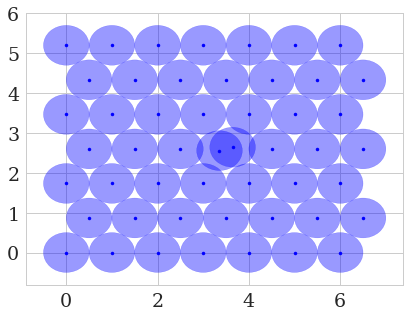

In [8]:
sheet = make_hexagonal_mesh(4)
plot_population(sheet)

## Cubic force

In [9]:
force = 'cubic'
tf = 60.0
t_data = [0.0,tf]

try:
    os.remove('step_sizes'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('AFs'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvalues'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvectors'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
    
n0 = 2


ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force], 'fix_eqs': n0*dim}, seed=seed)

eigenvalues_cubic = np.loadtxt('eigenvalues'+filename_ending['cubic']+'.txt')
eigenvectors_cubic = np.loadtxt('eigenvectors'+filename_ending['cubic']+'.txt')
eigenvectors_cubic = eigenvectors_cubic.reshape((-1,(50-n0)*dim, (50-n0)*dim), order='F')



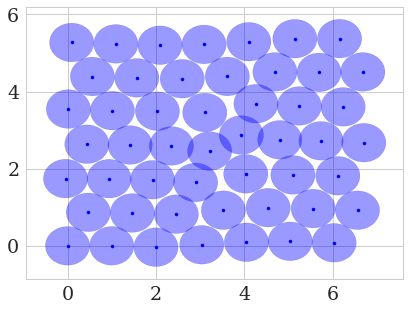

In [10]:
plot_population(history[-1])

### Count number of negative, zero and positive eigenvalues

In [11]:
eigenvalues_cubic.shape

(426, 96)

In [12]:
np.count_nonzero(np.isclose(eigenvalues_cubic, 0, atol=0.00000001), axis=1) # zero eigenvalues

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [13]:
np.count_nonzero(eigenvalues_cubic > 0.00000001, axis=1) # positive eigenvalues

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [14]:
eigenvalues_cubic[-1,:]

array([-1.36950610e+01, -9.92472067e+00, -9.44910675e+00, -9.15536196e+00,
       -7.77936973e+00, -7.71638419e+00, -7.54219335e+00, -7.50534406e+00,
       -7.12106569e+00, -6.96632672e+00, -6.94029976e+00, -6.78988812e+00,
       -6.75588197e+00, -6.60484439e+00, -6.53410243e+00, -6.50610451e+00,
       -6.41663727e+00, -6.22058268e+00, -5.99270467e+00, -5.96017817e+00,
       -5.83637854e+00, -5.69524346e+00, -5.63134927e+00, -5.52189022e+00,
       -5.22583149e+00, -5.12672757e+00, -5.03705994e+00, -4.90395891e+00,
       -4.78577102e+00, -4.67036460e+00, -4.64468718e+00, -4.59268098e+00,
       -4.45239005e+00, -4.30233508e+00, -4.19358072e+00, -4.08329729e+00,
       -3.97969486e+00, -3.86775402e+00, -3.79831028e+00, -3.57797933e+00,
       -3.51370023e+00, -3.37162214e+00, -3.30613427e+00, -3.23641534e+00,
       -3.13243421e+00, -3.02303157e+00, -2.97506474e+00, -2.87767019e+00,
       -2.75841503e+00, -2.67237048e+00, -2.62873131e+00, -2.52994807e+00,
       -2.49027317e+00, -

In [15]:
eigenvectors_cubic.shape

(426, 96, 96)

In [16]:
eigenvectors_cubic[-1, :, -4]

array([ 0.01808145,  0.05224682,  0.04204823,  0.18176285,  0.01712301,
        0.19535114,  0.00940914,  0.07829196,  0.00649575, -0.04480249,
       -0.03298178, -0.00844758, -0.04039371,  0.02241542, -0.0438184 ,
        0.07392311,  0.04651011,  0.21683925,  0.07913416,  0.12964423,
        0.09633153,  0.00430354,  0.09288903, -0.0950489 , -0.08649126,
       -0.04294411, -0.08026973,  0.00252626, -0.08916895,  0.04719186,
       -0.11631228,  0.06494339,  0.18644425,  0.19572983,  0.16731491,
        0.03398177,  0.15682671, -0.04967975, -0.09027757, -0.03808267,
       -0.05720739,  0.00251661,  0.00522072,  0.02834289, -0.06602572,
        0.20785548, -0.02899334, -0.02914103,  0.04918367, -0.06370987,
        0.08207893, -0.05601345, -0.16652797, -0.06698704, -0.16052889,
       -0.03505776, -0.16676002, -0.02659954, -0.21162186, -0.06958426,
        0.21285389,  0.05011729,  0.1499464 , -0.0620803 ,  0.1323742 ,
       -0.07469799, -0.16777318, -0.05040519, -0.14958805, -0.03

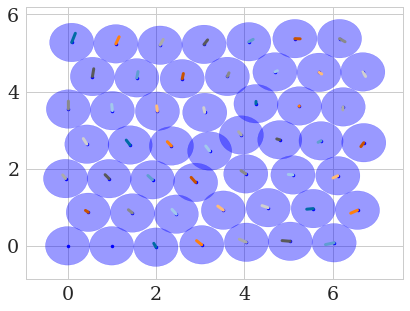

In [17]:
time_index = -1
plot_eigenvector_on_population(history[time_index], eigenvectors_cubic[time_index, :, -3], n0) # zero eigenvalue = translation in y

In [18]:
time_index = -1
plot_eigenvector_on_population(history[time_index], eigenvectors_cubic[time_index, :, -2], n0) # second zero eigenvalue = translation in x

TypeError: plot_eigenvector_on_population() missing 1 required positional argument: 'n0'

In [ ]:
time_index = -1
plot_eigenvector_on_population(history[time_index], eigenvectors_cubic[time_index, :, -1], n0) # positive eigenvalue = rotation

Continue running the simulation to check if this state really is stable.

In [ ]:
tf = 60.0
t_data = [0.0,tf]

try:
    os.remove('step_sizes'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('AFs'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvalues'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvectors'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
    
n0 = 2
ts, history = models_ef[force].simulate(history[-1], t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force], 'fix_eqs': n0*dim}, seed=seed)

eigenvalues_cubic = np.loadtxt('eigenvalues'+filename_ending['cubic']+'.txt')
eigenvectors_cubic = np.loadtxt('eigenvectors'+filename_ending['cubic']+'.txt')
eigenvectors_cubic = eigenvectors_cubic.reshape((-1,(50-n0)*dim, (50-n0)*dim), order='F')

In [ ]:
plot_population(history[-1])

Looks like it is!

## PWQ force

In [10]:
force = 'pw. quad.'
tf = 60.0
t_data = [0, tf]

try:
    os.remove('step_sizes'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('AFs'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvalues'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvectors'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
n0=2
ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force], 'fix_eqs': n0*dim}, seed=seed)

eigenvalues_pwq = np.loadtxt('eigenvalues'+filename_ending[force]+'.txt')
eigenvectors_pwq = np.loadtxt('eigenvectors'+filename_ending[force]+'.txt')
eigenvectors_pwq = eigenvectors_pwq.reshape((-1,(50-n0)*dim, (50-n0)*dim), order='F')


Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.


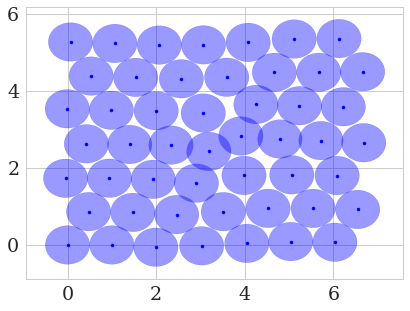

In [11]:
plot_population(history[-1])

In [12]:
np.count_nonzero(np.isclose(eigenvalues_pwq, 0, atol=0.00001), axis=1) # zero eigenvalues

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [13]:
np.count_nonzero(eigenvalues_pwq > 0.00001, axis=1) # positive eigenvalues

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [14]:
eigenvalues_pwq[-1,:]

array([-1.26029710e+01, -9.63244807e+00, -9.59813656e+00, -8.97535324e+00,
       -8.01866070e+00, -7.97943545e+00, -7.87836966e+00, -7.74005562e+00,
       -7.42002307e+00, -7.27487547e+00, -7.21905976e+00, -7.11970675e+00,
       -7.00105366e+00, -6.93857089e+00, -6.91092658e+00, -6.74509531e+00,
       -6.65445042e+00, -6.44214498e+00, -6.26939839e+00, -6.23994164e+00,
       -6.08524765e+00, -5.98661106e+00, -5.77102336e+00, -5.67382395e+00,
       -5.49226510e+00, -5.33181139e+00, -5.24731192e+00, -5.04620890e+00,
       -5.01173249e+00, -4.95273706e+00, -4.84283380e+00, -4.78478519e+00,
       -4.60623091e+00, -4.50326824e+00, -4.41394720e+00, -4.22518681e+00,
       -4.16688076e+00, -4.05651710e+00, -3.92117003e+00, -3.72251736e+00,
       -3.68675196e+00, -3.52385543e+00, -3.41332387e+00, -3.36004724e+00,
       -3.28610044e+00, -3.19634394e+00, -3.08460646e+00, -3.02422180e+00,
       -2.92694857e+00, -2.80477272e+00, -2.66143988e+00, -2.64372681e+00,
       -2.59677519e+00, -

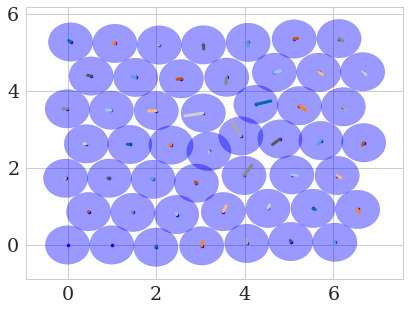

In [15]:
time_index = -1
plot_eigenvector_on_population(history[time_index], eigenvectors_pwq[time_index, :, -1], n0) # zero eigenvalue = translation in y

In [16]:
new_init = history[-1]

In [17]:
tf = 60.0
t_data = [0, tf]

try:
    os.remove('step_sizes'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('AFs'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvalues'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvectors'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')

n0=2
ts, history = models_ef[force].simulate(new_init, t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force], 'fix_eqs': n0*dim}, seed=seed)

eigenvalues_pwq = np.loadtxt('eigenvalues'+filename_ending[force]+'.txt')
eigenvectors_pwq = np.loadtxt('eigenvectors'+filename_ending[force]+'.txt')
eigenvectors_pwq = eigenvectors_pwq.reshape((-1,(50-n0)*dim, (50-n0)*dim), order='F')


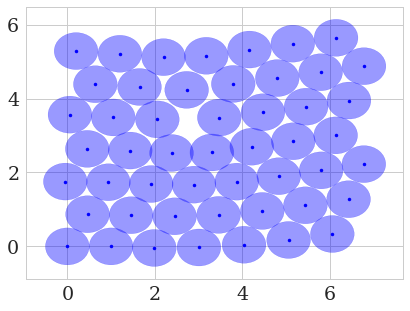

In [18]:
plot_population(history[-1])

In [20]:
eigenvalues_pwq[-1,:]

array([-1.02773089e+01, -9.22958240e+00, -8.87650613e+00, -8.64748672e+00,
       -8.24351367e+00, -8.21609734e+00, -8.04357151e+00, -7.95400455e+00,
       -7.88474936e+00, -7.63335692e+00, -7.51120269e+00, -7.47497655e+00,
       -7.29011111e+00, -7.19417659e+00, -7.10603018e+00, -6.99938635e+00,
       -6.81207019e+00, -6.65143345e+00, -6.59592661e+00, -6.39216207e+00,
       -6.10103083e+00, -6.08001750e+00, -5.97844840e+00, -5.89259549e+00,
       -5.63299814e+00, -5.53858127e+00, -5.49208737e+00, -5.38997096e+00,
       -5.27894032e+00, -5.10545757e+00, -5.03408918e+00, -4.85869245e+00,
       -4.77549462e+00, -4.52238095e+00, -4.40577787e+00, -4.36696176e+00,
       -4.30530166e+00, -4.13370443e+00, -4.06761180e+00, -3.98104033e+00,
       -3.86303898e+00, -3.64930513e+00, -3.64657479e+00, -3.52425551e+00,
       -3.49404208e+00, -3.37313768e+00, -3.31772831e+00, -3.25909057e+00,
       -3.11070379e+00, -3.08357659e+00, -2.98266470e+00, -2.86611270e+00,
       -2.84855235e+00, -

In [21]:
np.count_nonzero(eigenvalues_pwq > 0.0000001, axis=1) # positive eigenvalues

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,

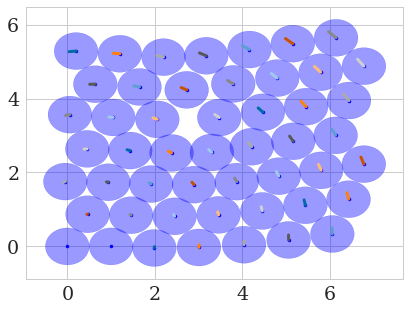

In [22]:
time_index = -1
plot_eigenvector_on_population(history[time_index], eigenvectors_pwq[time_index, :, -1], n0) # zero eigenvalue = translation in y

Now there's no positive eigenvalue left. 

## GLS force

In [23]:
force = 'GLS'
tf = 60.0
t_data = [0, tf]

try:
    os.remove('step_sizes'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('AFs'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvalues'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvectors'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')

n0=2
ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force], 'fix_eqs': n0*dim}, seed=seed)

eigenvalues_gls = np.loadtxt('eigenvalues'+filename_ending['GLS']+'.txt')
eigenvectors_gls = np.loadtxt('eigenvectors'+filename_ending['GLS']+'.txt')
eigenvectors_gls = eigenvectors_gls.reshape((-1,(50-n0)*dim, (50-n0)*dim), order='F')


In [25]:
new_init = history[-1]

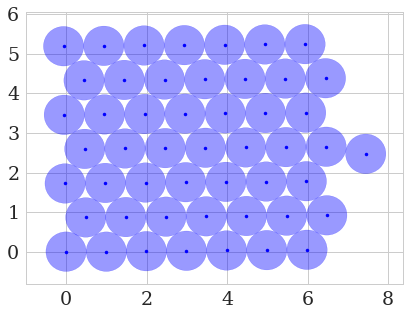

In [26]:
plot_population(new_init)

In [27]:
eigenvalues_gls[-1,:]

array([-1.10609253e+01, -1.10017595e+01, -1.09064384e+01, -1.05406402e+01,
       -1.04510497e+01, -1.03879126e+01, -1.00567719e+01, -1.00195908e+01,
       -9.93582707e+00, -9.79232072e+00, -9.68526150e+00, -9.52689089e+00,
       -9.35901100e+00, -9.34404058e+00, -9.18806067e+00, -9.15744765e+00,
       -8.94101602e+00, -8.82710771e+00, -8.78231514e+00, -8.60264449e+00,
       -8.33175201e+00, -8.20867002e+00, -7.83200017e+00, -7.65463935e+00,
       -7.55024432e+00, -7.24232582e+00, -7.14493408e+00, -7.00187448e+00,
       -6.97457017e+00, -6.70267939e+00, -6.53736805e+00, -6.32291418e+00,
       -6.24065130e+00, -6.00533817e+00, -5.78298961e+00, -5.61637270e+00,
       -5.57418877e+00, -5.33398181e+00, -5.26681759e+00, -5.10956560e+00,
       -5.02278498e+00, -4.82672718e+00, -4.70286847e+00, -4.69488773e+00,
       -4.56879694e+00, -4.42254040e+00, -4.25198001e+00, -4.13719952e+00,
       -4.10977317e+00, -4.07665345e+00, -4.02513676e+00, -3.80784417e+00,
       -3.76087204e+00, -

In [28]:
np.count_nonzero(np.isclose(eigenvalues_gls, 0, atol=0.0000001), axis=1) # zero eigenvalues

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [29]:
np.count_nonzero(eigenvalues_gls > 0.000001, axis=1) # positive eigenvalues

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [30]:
tf = 60.0
t_data = [0, tf]

try:
    os.remove('step_sizes'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('AFs'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvalues'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvectors'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')

n0=2
ts, history = models_ef[force].simulate(new_init, t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force], 'fix_eqs': n0*dim}, seed=seed)

eigenvalues_gls = np.loadtxt('eigenvalues'+filename_ending['GLS']+'.txt')
eigenvectors_gls = np.loadtxt('eigenvectors'+filename_ending['GLS']+'.txt')
eigenvectors_gls = eigenvectors_gls.reshape((-1,(50-n0)*dim, (50-n0)*dim), order='F')


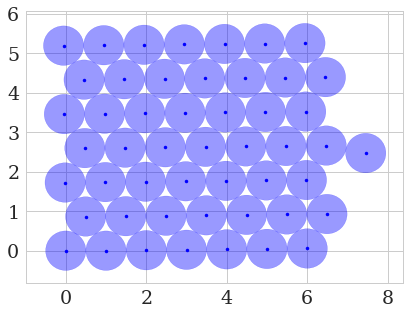

In [31]:
plot_population(history[-1])

In [32]:
np.count_nonzero(np.isclose(eigenvalues_gls, 0, atol=0.0000000001), axis=1) # zero eigenvalues

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [33]:
np.count_nonzero(eigenvalues_gls > 0.000000001, axis=1) # positive eigenvalues

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [34]:
eigenvalues_gls[-1,:]

array([-1.10745939e+01, -1.10496498e+01, -1.09639430e+01, -1.05899096e+01,
       -1.04582300e+01, -1.04496977e+01, -1.01035346e+01, -1.00438578e+01,
       -9.95298815e+00, -9.81872909e+00, -9.73928075e+00, -9.55362822e+00,
       -9.40418385e+00, -9.37424732e+00, -9.21908994e+00, -9.19718979e+00,
       -8.98206783e+00, -8.85897932e+00, -8.79168241e+00, -8.62431938e+00,
       -8.33476541e+00, -8.24553885e+00, -7.85780829e+00, -7.70314691e+00,
       -7.57858255e+00, -7.27557087e+00, -7.15962900e+00, -7.02455867e+00,
       -7.00074169e+00, -6.70206124e+00, -6.57873944e+00, -6.34695173e+00,
       -6.26536342e+00, -6.01679306e+00, -5.79827401e+00, -5.62728866e+00,
       -5.58813444e+00, -5.35576605e+00, -5.28974103e+00, -5.12052786e+00,
       -5.03919785e+00, -4.83834681e+00, -4.72523597e+00, -4.70960946e+00,
       -4.58576718e+00, -4.43452529e+00, -4.26242489e+00, -4.14612014e+00,
       -4.11774200e+00, -4.09591326e+00, -4.04716575e+00, -3.81809804e+00,
       -3.77065847e+00, -

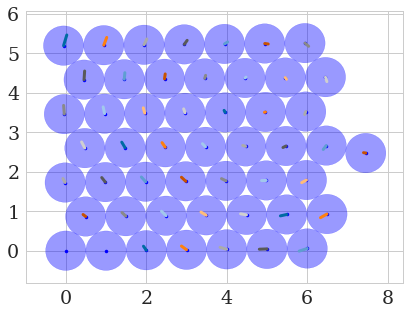

In [35]:
time_index = -1
plot_eigenvector_on_population(history[time_index], eigenvectors_gls[time_index, :, -4], n0) # zero eigenvalue = translation in y